# Dog Breed Classifier

This project uses deep learning and neural networks (TensorFlow) to create an image classifier which predicts dog breeds.

## 1. Problem
Identifying dog breeds based off of images using Transfer Learning.

## 2. Data
The data was from Kaggle's dog breed identification competition ([kaggle.com/c/dog-breed-identification](https://kaggle.com/c/dog-breed-identification))

## 3. Evaluation
The model is evaluated based off of the Multi Class Log Loss (MCLL) on the model's predictive probabilities on the test data. The lower the MCLL, the better the model. More information can be found in the Kaggle Evaluation section.
https://kaggle.com/c/dog-breed-identification/overview/evaluation

I will also evaluate the model on accuracy.

## 4. Features
This project involves unstructured data (images) and therefore deep learning will be used.
* There are 120 breeds of dogs, with over 10,000+ images in both the test and train sets
* The training images have labels while the test don't

In [ ]:
# Getting data
import os
os.chdir("/content/")
 
!pwd
!git clone https://github.com/daniyal-d/Dog-Breed-Recognition
os.chdir("/content/")

/content
Cloning into 'Dog-Breed-Recognition'...
remote: Enumerating objects: 20592, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 20592 (delta 27), reused 98 (delta 27), pack-reused 20494
Receiving objects: 100% (20592/20592), 782.60 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Checking out files: 100% (20597/20597), done.


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import tensorflow as tf
import tensorflow_hub as hub

if tf.config.list_physical_devices("GPU"):
  print("GPU working")
else:
  print("GPU not working")

GPU working


In [ ]:
# Converting images into tensors (converting images into numerical format)
labels_csv = pd.read_csv("/content/Dog-Breed-Recognition/labels.csv")
labels_csv.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Getting number of images for each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,20));

In [ ]:
labels_csv["breed"].value_counts().median()

In [ ]:
# Viewing image of a dog (Boston Bulldog)
from IPython.display import Image
Image("/content/Dog-Breed-Recognition/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [ ]:
# Getting pathnames from image IDs

pathnames = ["/content/Dog-Breed-Recognition/train/" + id + ".jpg" for id in labels_csv["id"]]
len(pathnames), len(labels_csv["id"])

In [ ]:
# Encoding dog labels

labels = np.array(labels_csv["breed"])
labels, len(labels)

In [ ]:
unique_breeds = np.unique(labels)
unique_breeds

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# one_hot = OneHotEncoder()
# categorical_value = ["breed"]
# transformer = ColumnTransformer([("one_hot",
#                                  one_hot,
#                                  categorical_value)],
#                                  remainder="passthrough")
# boolean_labels = transformer.fit_transform(labels_csv)


# print(boolean_labels[:1])

encoded_labels = [label == unique_breeds for label in labels]
encoded_labels[:1]

### Creating a validation set

In [ ]:
X = pathnames
y = encoded_labels

There are 10000 images. Because testing on all of these would take too long, only 1000 will be used.



In [ ]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}


In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
X_train, X_validation, y_train, y_validation = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2)

len(X_train), len(y_train), len(X_validation), len(y_validation)

In [ ]:
# Converting images to Tensors and resizing them

IMG_SIZE = 224

def preprocess_image(path, img_size=IMG_SIZE):
  image = tf.io.read_file(path)

  # Creating RGB values
  image = tf.image.decode_jpeg(image, channels=3)

  # Normalizing RGB values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

## Converting images into batches

This is done to save memory and speed up training. Rather than have the model train on all images at once, it trains on smaller "batches" of images.

In [ ]:
# Converting image path and label to tuple

def get_image_label_tuple(path, label):
  image = preprocess_image(path)
  return image, label

In [ ]:
# Creating batches for X and y data
BATCH_SIZE = 32

def create_batch(X, y=None, batch_size=BATCH_SIZE, validation=False, test=False):
  if test:
    print("Test Data")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch
  
  elif validation:
    print("Validation Data")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label_tuple).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Training Data")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label_tuple)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
train_data = create_batch(X_train, y_train)
validation_data = create_batch(X_validation, y_validation, validation=True)

In [ ]:
train_data.element_spec, validation_data.element_spec


In [ ]:
# Visualizing the data batches

def show_25_images(images, labels):
  plt.figure(figsize=(12,12))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())

In [ ]:
show_25_images(train_images, train_labels)

In [ ]:
validation_images, validation_labels =  next(validation_data.as_numpy_iterator())

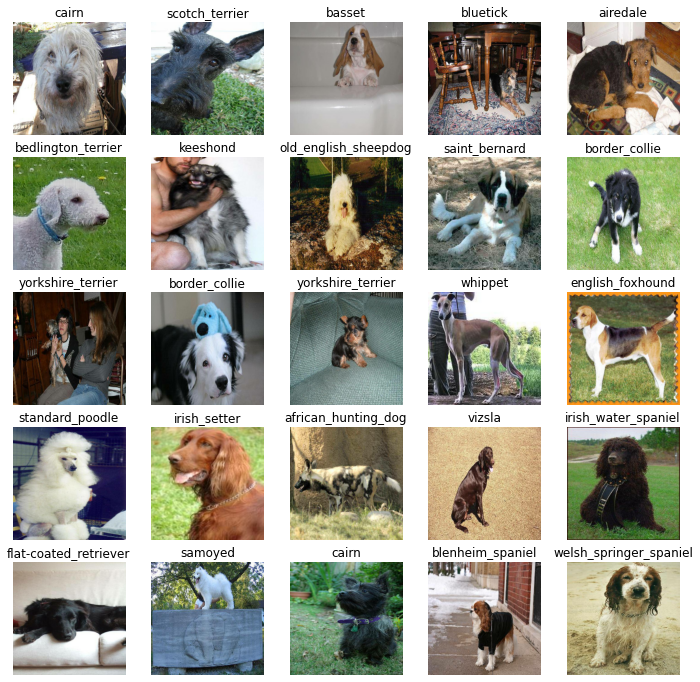

In [ ]:
show_25_images(validation_images, validation_labels)

## Creating the model

* The input shape is the image shape (Tensors)
* The output shape is the image labels (Tensors)

In [ ]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

OUTPUT_SHAPE = len(unique_breeds)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

resnet_v2_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [ ]:
# Building Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f"Building model with {model_url}")

  model = tf.keras.Sequential([
                              hub.KerasLayer(MODEL_URL),
                              tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")
  ])

  # Compiling model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

## Callbacks

Callbacks are functions models use throughout training to check progress. Not only do they evaluate how well a model is training, but it can also stop a model from running if it isn't improving (which saves a lot of time and **prevents overfitting**)

A callback for TensorBoard (checking progress) and for early stopping will be created

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime

def create_tensorboard_callback():
  logdir = os.path.join("/content/Dog-Breed-Recognition/logs", datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S"))

  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping_val_accuracy = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

## Training the model

Initially the model will only be trained on 1000 images. This is to check if it's working,

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
if tf.config.list_physical_devices("GPU"):
  print("GPU working")
else:
  print("GPU not working")

In [ ]:
# Training model
def train_model(early_stopping_callback=early_stopping_val_accuracy):
  model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=validation_data, validation_freq=1, callbacks=[tensorboard, early_stopping_callback])
  return model

In [ ]:
# Train on validation accuracy
np.random.seed(42)
model = train_model(early_stopping_callback=early_stopping_val_accuracy)

In [ ]:
# Shows that current model is overfitting

%tensorboard --logdir /content/Dog-Breed-Recognition/logs

In [ ]:
# Making predictions with the model

# Get predictions on validation set
preds = model.predict(validation_data, verbose=1)
preds

In [ ]:
preds.shape

In [ ]:
len(y_validation)

In [ ]:
# Each individual preds shows the model's predicted probability of a dog being a certain breed
preds[0], np.sum(preds[0])

In [ ]:
# First prediction (not going to be good)
index = 0
print(f"Max value (probability of prediction): {np.max(preds[index])}")
print(f"Sum: {np.sum(preds[index])}")
print(f"Max index: {np.argmax(preds[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(preds[index])]}")

In [ ]:
unique_breeds[0]

In [ ]:
# Assigning probabilities to dog breeds

def get_pred_breed(prediciton_probs):
  return unique_breeds[np.argmax(prediciton_probs)]

pred_breed = get_pred_breed(preds[0])
pred_breed

In [ ]:
def unbatch_data(data):
  images_unbatched = []
  labels_unbatched = []

  for image, label in validation_data.unbatch().as_numpy_iterator():
    images_unbatched.append(image)
    labels_unbatched.append(unique_breeds[np.argmax(label)])
  
  return images_unbatched, labels_unbatched

In [ ]:
validation_images_unbatched, validation_labels_unbatched = unbatch_data(validation_data)
validation_images_unbatched[0], validation_labels_unbatched[0]

In [ ]:
get_pred_breed(validation_labels_unbatched[0])

## Visualizing predictions and actual values

In [ ]:
def plot_pred(prediction_probs, labels, images, n=1):
  pred_prob, true_label, image = prediction_probs[n], labels[n], images[n]

  pred_label = get_pred_breed(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color="green"
  else:
    color="red"
  plt.title((f"Prediction: {pred_label} ({np.max(pred_prob)*100:2.0f}% confidence). Actual breed: {true_label}"), color=color)

In [ ]:
plot_pred(prediction_probs=preds, labels=validation_labels_unbatched, images=validation_images_unbatched)

In [ ]:
plot_pred(prediction_probs=preds, labels=validation_labels_unbatched, images=validation_images_unbatched, n=16)

In [ ]:
def plot_pred_confidence(prediction_probs, labels, n=1):
  """
  Plots the 10 most confident predictions
  """

  pred_prob, true_label = prediction_probs[n], labels[n]

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color="red")
  plt.xticks(np.arange(len(top_10_pred_labels)), labels=top_10_pred_labels, rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    plot[np.argmax(top_10_pred_labels == true_label)].set_color("red")


In [ ]:
plot_pred_confidence(prediction_probs=preds, labels=validation_labels_unbatched)

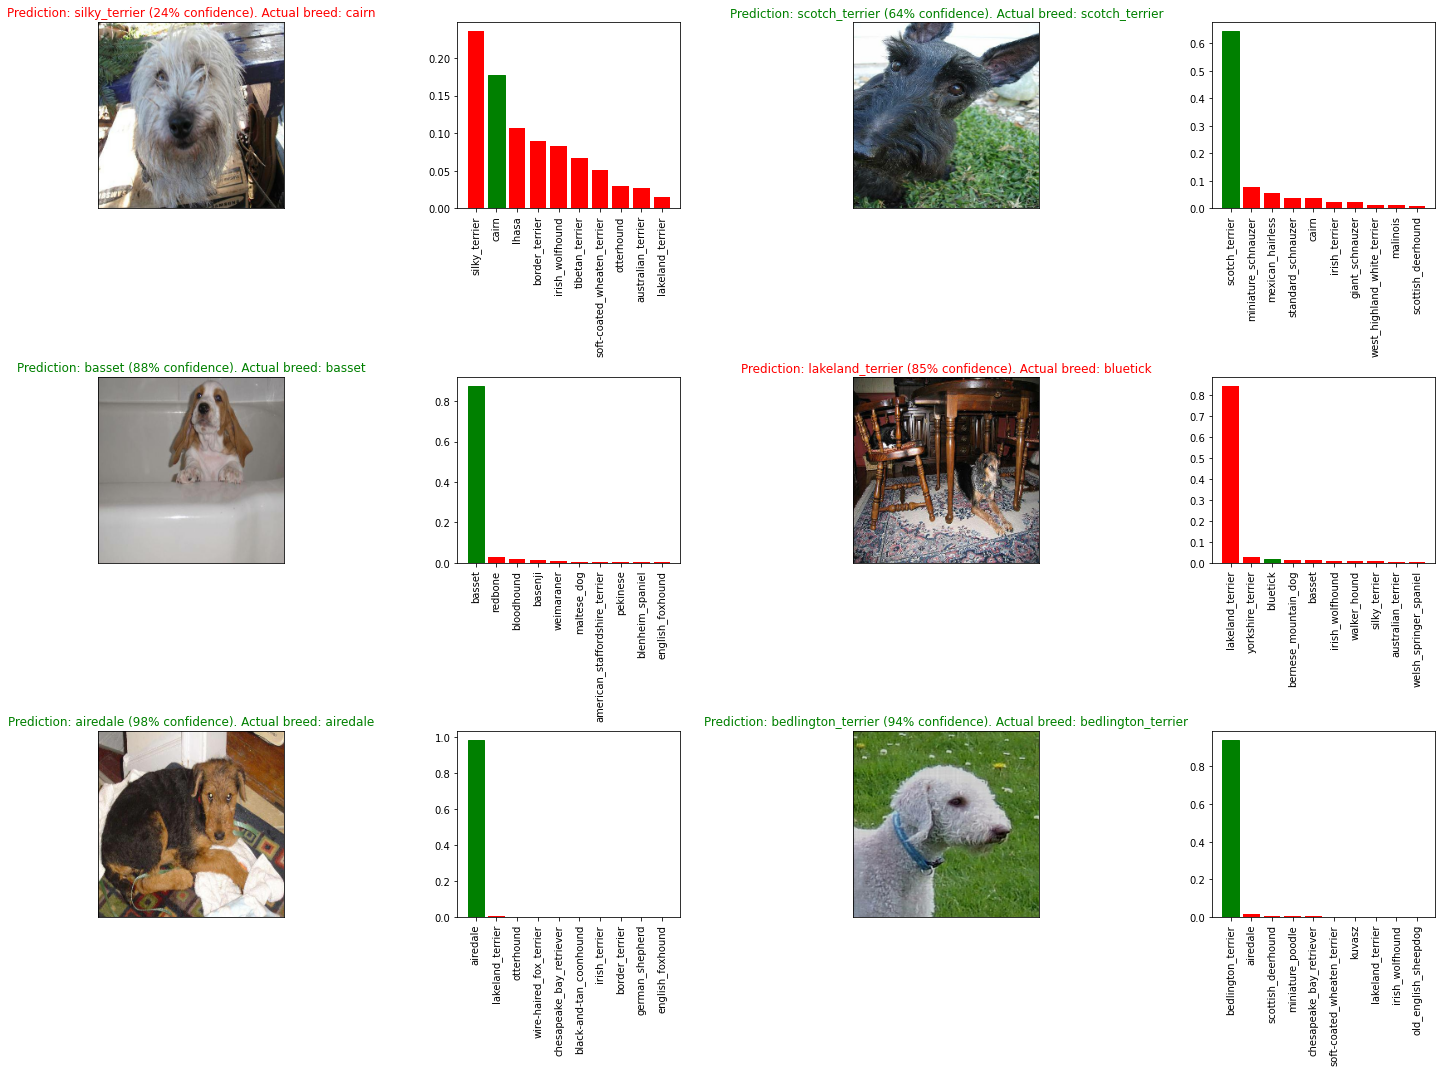

In [128]:
# Viewing predictions and their values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probs=preds,
            labels=validation_labels_unbatched,
            images=validation_images_unbatched,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_confidence(prediction_probs=preds,
                labels=validation_labels_unbatched,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
# Saving the current model

def save_model(model, suffix=None):
  model_directory = os.path.join("/content/Dog-Breed-Recognition/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = model_directory + '-' + suffix + '.h5'
  model.save(model_path)

  return model_path

In [ ]:
def load_model(model_path):
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save the model trained on 1000 images
# save_model(model, suffix="1000-images-mobilenetv2-Adam")

In [ ]:
loaded_1000_image_model = load_model("/content/Dog-Breed-Recognition/models/20220715-07281657870122-1000-images-mobilenetv2-Adam.h5")

In [ ]:
model.evaluate(validation_data)

In [ ]:
# This loaded model was from a previous run
loaded_1000_image_model.evaluate(validation_data)

In [ ]:
# Viewing saved model predictions and values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

loaded_1000_model_preds = loaded_1000_image_model.predict(validation_data, verbose=1)

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probs=loaded_1000_model_preds,
            labels=validation_labels_unbatched,
            images=validation_images_unbatched,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_confidence(prediction_probs=loaded_1000_model_preds,
                labels=validation_labels_unbatched,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Training on all data

In [ ]:
# Creating data batches with data set
full_data = create_batch(X, y)

In [ ]:
full_data

In [ ]:
full_model = create_model()

In [ ]:
full_model_tensorboard = create_tensorboard_callback()
full_model_early_stopping_accuracy = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)
full_model_early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

In [ ]:
# Fitting model for accuracy
# full_model.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping_accuracy])

In [ ]:
# save_model(full_model, suffix="full-image-set-accuracy-mobilenetv2-Adam")

In [ ]:
# Fitting model for loss (what the competition evaluates participants on)
#  full_model_loss = create_model()
#  full_model_loss.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping_loss])

In [ ]:
# Fitting model with ResNet

# full_model_resnet = create_model(model_url=resnet_v2_url)
# full_model_resnet.fit(x=full_data, epochs=NUM_EPOCHS, callbacks=[full_model_tensorboard, full_model_early_stopping_accuracy])

In [ ]:
# save_model(full_model_resnet, suffix="full-image-set-accuracy-resnetv2")

In [72]:
loaded_full_accuracy_resnet = load_model("/content/Dog-Breed-Recognition/models/20220717-08231658046232-full-image-set-accuracy-resnetv2.h5")
loaded_full_accuracy_resnet.evaluate(full_data)

320/320 [==============================] - 32s 96ms/step - loss: 0.0113 - accuracy: 0.9993


[0.0112832710146904, 0.9993152022361755]

In [69]:
# save_model(full_model_loss, suffix="full-image-set-loss-mobilenetv2-Adam")

In [70]:
loaded_full_loss_model = load_model("/content/Dog-Breed-Recognition/models/20220716-08041657958667-full-image-set-loss-mobilenetv2-Adam.h5")
loaded_full_loss_model.evaluate(full_data)

320/320 [==============================] - 28s 85ms/step - loss: 0.0140 - accuracy: 0.9984


[0.013986465521156788, 0.9984347224235535]

In [73]:
loaded_full_accuracy_model = load_model("/content/Dog-Breed-Recognition/models/20220716-07431657957390-full-image-set-accuracy-mobilenetv2-Adam.h5")
loaded_full_accuracy_model.evaluate(full_data)

320/320 [==============================] - 24s 74ms/step - loss: 0.0116 - accuracy: 0.9990


[0.011600557714700699, 0.9990217089653015]

In [74]:
loaded_loss_model2 = load_model("/content/Dog-Breed-Recognition/models/20220716-20291658003342-full-image-set-loss-second-mobilenetv2-Adam.h5")
loaded_loss_model2.evaluate(full_data)

320/320 [==============================] - 25s 75ms/step - loss: 0.0068 - accuracy: 0.9988


[0.00675292918458581, 0.9988260865211487]

# The model trained for accuracy has better loss and accuracy compared to original loss trained model. 
# The second loss trained model (same as the original but trained on a newly shuffled dataset) has better loss but worse accuracy. 
# Resnet does have a better loss and accuracy on the training data compared to the accuracy model, but the accuracy model actually had a lower log loss on the test data.

In [75]:
# Making predictions on the test dataset
test_path = "/content/Dog-Breed-Recognition/test/"
test_pathnames = [test_path + fname for fname in os.listdir(test_path)]
test_pathnames[:15]

['/content/Dog-Breed-Recognition/test/c0c536f83a3b465cc13e547e8ce3fd23.jpg',
 '/content/Dog-Breed-Recognition/test/7ef719ad1c8b98ffdaff289c209b470c.jpg',
 '/content/Dog-Breed-Recognition/test/450523885568f0eb7b4566883bb8006d.jpg',
 '/content/Dog-Breed-Recognition/test/5c873a3533849b784d2f250167eb7a70.jpg',
 '/content/Dog-Breed-Recognition/test/70039f70843e71c099d8498229844434.jpg',
 '/content/Dog-Breed-Recognition/test/7a62461293270d78481a88d433b4df36.jpg',
 '/content/Dog-Breed-Recognition/test/20654ff0191d11ccbcde05f4204fe3b3.jpg',
 '/content/Dog-Breed-Recognition/test/2a43b986457a491c2efb3a055bb3fa90.jpg',
 '/content/Dog-Breed-Recognition/test/629a627eb84b246338859ebb6387183d.jpg',
 '/content/Dog-Breed-Recognition/test/3247a9afc5171760dbaea74c5239a4a0.jpg',
 '/content/Dog-Breed-Recognition/test/7a1d4ba9de9cd60a0db3c523165a643f.jpg',
 '/content/Dog-Breed-Recognition/test/2fcb0bce7107a87563f3d0eb04c599a8.jpg',
 '/content/Dog-Breed-Recognition/test/cd3a666d082b6cb9a44ddb1dca5eedc9.jpg',

In [76]:
# Converting to Tensor batches
test_data = create_batch(X=test_pathnames, test=True)

Test Data


In [77]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [78]:
# Making predictions with model trained on accuracy
test_preds = loaded_full_accuracy_model.predict(test_data, verbose=1)

324/324 [==============================] - 28s 84ms/step


In [79]:
test_preds

array([[1.0784360e-04, 1.0500245e-10, 3.1546392e-08, ..., 3.1218794e-06,
        1.2643401e-04, 3.3099991e-06],
       [7.8574392e-13, 8.7738749e-12, 2.7685437e-11, ..., 5.5483913e-11,
        2.0328711e-11, 3.8517586e-10],
       [4.3812559e-10, 3.5622123e-11, 2.0310354e-07, ..., 5.2603150e-10,
        2.7923299e-11, 1.6735694e-12],
       ...,
       [6.3970685e-05, 6.0506322e-10, 4.5022365e-08, ..., 7.7732643e-08,
        2.4655301e-03, 1.0930577e-01],
       [2.3704597e-12, 2.5086647e-13, 1.9416097e-13, ..., 2.0903010e-11,
        3.6402945e-14, 5.4542328e-14],
       [5.2946862e-06, 1.3934433e-08, 1.8650078e-07, ..., 3.0369021e-04,
        7.6206888e-05, 4.5911928e-08]], dtype=float32)

In [80]:
# Saving accuracy predicitons
# np.savetxt("/content/Dog-Breed-Recognition/test_preds_accuracy.csv", test_preds, delimiter=",")
test_preds_accuracy = np.loadtxt("/content/Dog-Breed-Recognition/test_preds_accuracy.csv", delimiter=",")
test_preds_accuracy

array([[1.07843603e-04, 1.05002451e-10, 3.15463922e-08, ...,
        3.12187944e-06, 1.26434010e-04, 3.30999910e-06],
       [7.85743920e-13, 8.77387486e-12, 2.76854373e-11, ...,
        5.54839126e-11, 2.03287109e-11, 3.85175863e-10],
       [4.38125591e-10, 3.56221233e-11, 2.03103539e-07, ...,
        5.26031496e-10, 2.79232991e-11, 1.67356938e-12],
       ...,
       [6.39706850e-05, 6.05063222e-10, 4.50223645e-08, ...,
        7.77326434e-08, 2.46553007e-03, 1.09305769e-01],
       [2.37045973e-12, 2.50866466e-13, 1.94160971e-13, ...,
        2.09030102e-11, 3.64029451e-14, 5.45423285e-14],
       [5.29468616e-06, 1.39344332e-08, 1.86500785e-07, ...,
        3.03690205e-04, 7.62068885e-05, 4.59119285e-08]])

In [81]:
# Making predicitons with 1st loss model
test_preds_loss1 = loaded_full_loss_model.predict(test_data, verbose=1)

324/324 [==============================] - 25s 76ms/step


In [82]:
test_preds_loss1

array([[6.6021610e-05, 1.3918131e-11, 1.1329977e-08, ..., 2.2744623e-06,
        2.7707985e-05, 5.8140745e-07],
       [6.9207261e-14, 8.9826231e-13, 4.0533692e-12, ..., 6.9499142e-12,
        1.9287291e-12, 7.2064271e-11],
       [1.0639125e-10, 8.4034845e-12, 7.1214373e-08, ..., 3.2312442e-10,
        3.8577856e-12, 1.8707617e-13],
       ...,
       [1.9037896e-05, 7.1786334e-11, 1.0899639e-08, ..., 7.0899073e-09,
        7.4210990e-04, 3.9268754e-02],
       [2.3608109e-13, 1.5653453e-14, 1.6008167e-14, ..., 6.9451554e-12,
        1.5280833e-15, 7.4568393e-15],
       [1.5847819e-06, 2.4244802e-09, 4.9892606e-08, ..., 8.1703634e-05,
        1.3011326e-05, 7.3002191e-09]], dtype=float32)

In [83]:
# Saving first loss model predictions
# np.savetxt("/content/Dog-Breed-Recognition/test_preds_loss1.csv", test_preds_loss1, delimiter=",")
test_preds_loss1_csv = np.loadtxt("/content/Dog-Breed-Recognition/test_preds_loss1.csv", delimiter=",")
test_preds_loss1_csv

array([[6.60216101e-05, 1.39181314e-11, 1.13299770e-08, ...,
        2.27446230e-06, 2.77079853e-05, 5.81407448e-07],
       [6.92072606e-14, 8.98262313e-13, 4.05336919e-12, ...,
        6.94991417e-12, 1.92872909e-12, 7.20642712e-11],
       [1.06391250e-10, 8.40348451e-12, 7.12143731e-08, ...,
        3.23124416e-10, 3.85778562e-12, 1.87076171e-13],
       ...,
       [1.90378960e-05, 7.17863338e-11, 1.08996394e-08, ...,
        7.08990733e-09, 7.42109900e-04, 3.92687544e-02],
       [2.36081093e-13, 1.56534535e-14, 1.60081671e-14, ...,
        6.94515539e-12, 1.52808333e-15, 7.45683930e-15],
       [1.58478190e-06, 2.42448017e-09, 4.98926056e-08, ...,
        8.17036344e-05, 1.30113258e-05, 7.30021910e-09]])

In [84]:
# Making predictions with 2nd loss model
test_preds_loss2 = loaded_loss_model2.predict(test_data, verbose=1)

324/324 [==============================] - 28s 84ms/step


In [85]:
test_preds_loss2

array([[2.2987262e-05, 5.0960490e-12, 1.6664823e-09, ..., 1.9557069e-06,
        1.7670909e-05, 2.6903820e-08],
       [1.7342571e-14, 5.8155886e-14, 2.9858603e-13, ..., 6.7082109e-13,
        1.1019394e-12, 1.4870274e-12],
       [3.7209363e-13, 2.2426028e-13, 7.7716339e-10, ..., 3.2853687e-13,
        1.1744680e-13, 2.6362924e-15],
       ...,
       [4.1027466e-05, 1.9740818e-11, 1.5918651e-08, ..., 1.4456183e-09,
        5.2537571e-04, 3.7714235e-02],
       [8.5435114e-15, 2.4036454e-17, 2.1917447e-16, ..., 6.8861529e-14,
        2.0376220e-17, 3.5309320e-16],
       [1.5504610e-07, 1.5174062e-10, 1.1878956e-09, ..., 2.6056112e-04,
        3.3372373e-05, 1.6498337e-09]], dtype=float32)

In [86]:
# Saving second loss model predicitons
# np.savetxt("/content/Dog-Breed-Recognition/test_preds_loss2.csv", test_preds_loss2, delimiter=",")
test_preds_loss2_csv = np.loadtxt("/content/Dog-Breed-Recognition/test_preds_loss2.csv", delimiter=",")
test_preds_loss2_csv

array([[2.29872621e-05, 5.09604902e-12, 1.66648229e-09, ...,
        1.95570692e-06, 1.76709091e-05, 2.69038196e-08],
       [1.73425710e-14, 5.81558862e-14, 2.98586026e-13, ...,
        6.70821092e-13, 1.10193939e-12, 1.48702741e-12],
       [3.72093632e-13, 2.24260280e-13, 7.77163389e-10, ...,
        3.28536867e-13, 1.17446797e-13, 2.63629243e-15],
       ...,
       [4.10274661e-05, 1.97408184e-11, 1.59186513e-08, ...,
        1.44561829e-09, 5.25375712e-04, 3.77142355e-02],
       [8.54351143e-15, 2.40364541e-17, 2.19174473e-16, ...,
        6.88615289e-14, 2.03762196e-17, 3.53093201e-16],
       [1.55046095e-07, 1.51740620e-10, 1.18789556e-09, ...,
        2.60561123e-04, 3.33723729e-05, 1.64983371e-09]])

In [87]:
# Making resnet accuracy model precitions
test_preds_accuracy_resnet = loaded_full_accuracy_resnet.predict(test_data, verbose=1)

324/324 [==============================] - 28s 84ms/step


In [88]:
test_preds_accuracy_resnet

array([[3.78003097e-05, 1.19585080e-11, 1.87880502e-08, ...,
        1.16875426e-05, 5.66564086e-05, 4.06040442e-07],
       [6.24341941e-13, 4.97707344e-12, 2.60910373e-11, ...,
        4.09788245e-11, 4.92044253e-11, 6.78392620e-11],
       [8.30685867e-11, 6.63841135e-11, 4.30128715e-08, ...,
        4.63851679e-10, 1.19173950e-11, 1.98690717e-12],
       ...,
       [7.12262918e-05, 3.31983108e-09, 5.57462215e-07, ...,
        1.94941929e-08, 1.12017347e-02, 6.28860369e-02],
       [7.81425976e-13, 4.04017301e-14, 1.19192215e-14, ...,
        1.12093546e-11, 9.73427204e-15, 3.19531456e-14],
       [1.35098117e-06, 1.55645408e-09, 1.33471332e-08, ...,
        2.91606062e-04, 3.65095038e-05, 1.19897878e-08]], dtype=float32)

In [89]:
np.savetxt("/content/Dog-Breed-Recognition/test_preds_resnet_accuracy.csv", test_preds_accuracy_resnet, delimiter=",")
test_preds_accuracy_resnet_csv = np.loadtxt("/content/Dog-Breed-Recognition/test_preds_resnet_accuracy.csv", delimiter=",")
test_preds_accuracy_resnet_csv

array([[3.78003097e-05, 1.19585080e-11, 1.87880502e-08, ...,
        1.16875426e-05, 5.66564086e-05, 4.06040442e-07],
       [6.24341941e-13, 4.97707344e-12, 2.60910373e-11, ...,
        4.09788245e-11, 4.92044253e-11, 6.78392620e-11],
       [8.30685867e-11, 6.63841135e-11, 4.30128715e-08, ...,
        4.63851679e-10, 1.19173950e-11, 1.98690717e-12],
       ...,
       [7.12262918e-05, 3.31983108e-09, 5.57462215e-07, ...,
        1.94941929e-08, 1.12017347e-02, 6.28860369e-02],
       [7.81425976e-13, 4.04017301e-14, 1.19192215e-14, ...,
        1.12093546e-11, 9.73427204e-15, 3.19531456e-14],
       [1.35098117e-06, 1.55645408e-09, 1.33471332e-08, ...,
        2.91606062e-04, 3.65095038e-05, 1.19897878e-08]])

In [90]:
# Adding labels to files
# Accuracy df
preds_accuracy_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_accuracy_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [91]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_accuracy_df["id"] = test_ids

In [92]:
# Adding prediction probabilities
preds_accuracy_df[list(unique_breeds)] = test_preds_accuracy
preds_accuracy_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,c0c536f83a3b465cc13e547e8ce3fd23,1.078436e-04,1.050025e-10,3.154639e-08,3.197404e-09,2.380288e-01,9.074289e-10,2.123406e-07,1.945100e-06,4.476265e-07,...,7.901817e-06,2.603085e-02,5.179530e-08,5.815632e-08,3.149541e-08,2.076489e-08,2.039752e-05,3.121879e-06,1.264340e-04,3.309999e-06
1,7ef719ad1c8b98ffdaff289c209b470c,7.857439e-13,8.773875e-12,2.768544e-11,1.564597e-10,1.378743e-07,3.832968e-10,3.661224e-11,1.648400e-10,7.459224e-09,...,1.638737e-08,7.779723e-11,3.743045e-06,6.826207e-09,9.999688e-01,5.009046e-11,2.715003e-09,5.548391e-11,2.032871e-11,3.851759e-10
2,450523885568f0eb7b4566883bb8006d,4.381256e-10,3.562212e-11,2.031035e-07,1.223465e-10,2.150252e-11,9.718957e-11,1.974847e-10,4.773732e-09,1.602409e-07,...,3.967808e-11,1.527974e-10,9.123843e-12,5.561503e-10,8.051901e-12,2.600088e-07,2.065890e-11,5.260315e-10,2.792330e-11,1.673569e-12
3,5c873a3533849b784d2f250167eb7a70,2.397340e-08,3.009041e-10,6.049402e-09,7.888087e-09,4.158264e-11,1.418531e-08,2.052242e-10,1.598060e-12,1.644940e-12,...,1.163092e-11,4.650774e-12,1.850489e-09,8.446889e-10,9.930744e-09,4.033204e-11,1.356030e-10,1.261255e-10,2.164145e-11,7.039290e-10
4,70039f70843e71c099d8498229844434,6.267202e-09,3.233964e-06,4.759747e-10,2.336603e-04,2.780900e-09,4.894730e-08,9.741716e-06,1.900675e-09,1.063465e-08,...,1.643442e-07,2.949432e-09,2.902883e-05,7.725530e-06,5.747986e-08,9.766490e-04,5.804564e-10,8.189063e-09,1.979401e-08,7.284247e-07


In [93]:
test_preds_accuracy

array([[1.07843603e-04, 1.05002451e-10, 3.15463922e-08, ...,
        3.12187944e-06, 1.26434010e-04, 3.30999910e-06],
       [7.85743920e-13, 8.77387486e-12, 2.76854373e-11, ...,
        5.54839126e-11, 2.03287109e-11, 3.85175863e-10],
       [4.38125591e-10, 3.56221233e-11, 2.03103539e-07, ...,
        5.26031496e-10, 2.79232991e-11, 1.67356938e-12],
       ...,
       [6.39706850e-05, 6.05063222e-10, 4.50223645e-08, ...,
        7.77326434e-08, 2.46553007e-03, 1.09305769e-01],
       [2.37045973e-12, 2.50866466e-13, 1.94160971e-13, ...,
        2.09030102e-11, 3.64029451e-14, 5.45423285e-14],
       [5.29468616e-06, 1.39344332e-08, 1.86500785e-07, ...,
        3.03690205e-04, 7.62068885e-05, 4.59119285e-08]])

In [ ]:
# preds_accuracy_df.to_csv("/content/Dog-Breed-Recognition/full-model-accuracy-submission.csv", index=False)

In [ ]:
# from google.colab import files
# files.download("/content/Dog-Breed-Recognition/full-model-accuracy-submission.csv")

In [94]:
# First loss dataset
preds_loss_df1 = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_loss_df1["id"] = test_ids
preds_loss_df1[list(unique_breeds)] = test_preds_loss1
preds_loss_df1.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,c0c536f83a3b465cc13e547e8ce3fd23,6.602161e-05,1.391813e-11,1.132998e-08,5.405183e-10,2.512009e-01,1.655192e-10,6.953557e-08,6.830398e-07,1.326352e-07,...,6.839899e-06,2.802560e-02,1.643977e-08,3.622572e-08,9.076585e-09,5.223231e-09,9.399320e-06,2.274462e-06,2.770799e-05,5.814074e-07
1,7ef719ad1c8b98ffdaff289c209b470c,6.920726e-14,8.982623e-13,4.053369e-12,1.116136e-11,4.040618e-08,4.862933e-11,5.203518e-12,2.283000e-11,1.434389e-09,...,2.314170e-09,1.020602e-11,1.126084e-06,1.002087e-09,9.999880e-01,4.734560e-12,6.553362e-10,6.949914e-12,1.928729e-12,7.206427e-11
2,450523885568f0eb7b4566883bb8006d,1.063912e-10,8.403485e-12,7.121437e-08,4.229692e-11,2.936394e-12,2.197124e-11,4.108873e-11,1.217437e-09,6.890259e-08,...,3.639841e-12,3.943431e-11,1.357691e-12,1.808323e-10,1.225382e-12,1.310654e-07,4.066047e-12,3.231244e-10,3.857786e-12,1.870762e-13
3,5c873a3533849b784d2f250167eb7a70,7.627126e-09,7.821315e-11,1.897354e-09,2.850511e-09,8.618635e-12,7.101728e-09,5.690480e-11,2.495109e-13,3.078641e-13,...,2.097306e-12,6.883216e-13,3.170821e-10,1.790385e-10,4.029184e-09,7.031454e-12,3.608930e-11,1.743711e-11,6.656485e-12,3.494129e-10
4,70039f70843e71c099d8498229844434,1.644869e-09,1.298194e-06,9.181547e-11,2.191135e-05,8.517728e-10,1.853187e-08,4.161968e-06,3.475319e-10,2.178512e-09,...,1.796537e-08,5.931720e-10,9.523533e-06,5.793992e-06,1.661459e-08,3.900333e-04,8.208635e-11,1.102047e-09,7.938688e-09,2.965942e-07


In [95]:
test_preds_loss1_csv

array([[6.60216101e-05, 1.39181314e-11, 1.13299770e-08, ...,
        2.27446230e-06, 2.77079853e-05, 5.81407448e-07],
       [6.92072606e-14, 8.98262313e-13, 4.05336919e-12, ...,
        6.94991417e-12, 1.92872909e-12, 7.20642712e-11],
       [1.06391250e-10, 8.40348451e-12, 7.12143731e-08, ...,
        3.23124416e-10, 3.85778562e-12, 1.87076171e-13],
       ...,
       [1.90378960e-05, 7.17863338e-11, 1.08996394e-08, ...,
        7.08990733e-09, 7.42109900e-04, 3.92687544e-02],
       [2.36081093e-13, 1.56534535e-14, 1.60081671e-14, ...,
        6.94515539e-12, 1.52808333e-15, 7.45683930e-15],
       [1.58478190e-06, 2.42448017e-09, 4.98926056e-08, ...,
        8.17036344e-05, 1.30113258e-05, 7.30021910e-09]])

In [96]:
# preds_loss_df1.to_csv("/content/Dog-Breed-Recognition/full-model-loss-1-submission.csv", index=False)

In [97]:
# from google.colab import files
# files.download("/content/Dog-Breed-Recognition/full-model-loss-1-submission.csv")

In [98]:
# Second loss dataset
preds_loss_df2 = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_loss_df2["id"] = test_ids
preds_loss_df2[list(unique_breeds)] = test_preds_loss2
preds_loss_df2.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,c0c536f83a3b465cc13e547e8ce3fd23,2.298726e-05,5.096049e-12,1.666482e-09,2.751350e-10,1.441966e-01,5.998295e-12,5.211059e-09,8.719915e-08,4.487429e-08,...,1.003747e-05,2.610395e-02,4.078576e-09,3.311441e-09,2.500403e-09,2.873004e-10,4.112922e-05,1.955707e-06,1.767091e-05,2.690382e-08
1,7ef719ad1c8b98ffdaff289c209b470c,1.734257e-14,5.815589e-14,2.985860e-13,2.468731e-13,4.138876e-09,5.631753e-13,1.502637e-12,2.393840e-13,2.312624e-10,...,3.554234e-09,1.177273e-13,1.517098e-07,2.703783e-10,9.999976e-01,6.811777e-15,3.912609e-10,6.708211e-13,1.101939e-12,1.487027e-12
2,450523885568f0eb7b4566883bb8006d,3.720936e-13,2.242603e-13,7.771634e-10,2.522827e-12,1.496339e-14,4.067426e-13,1.186891e-11,1.922748e-11,4.826293e-09,...,1.783037e-14,2.933181e-12,1.852619e-14,3.148825e-12,1.445013e-14,2.726088e-09,3.816164e-13,3.285369e-13,1.174468e-13,2.636292e-15
3,5c873a3533849b784d2f250167eb7a70,8.889508e-10,3.395468e-12,5.436263e-11,6.165974e-10,1.675460e-12,2.296137e-10,8.266288e-12,5.329783e-15,6.773714e-14,...,1.900662e-14,1.449653e-14,9.932495e-12,3.193608e-11,2.554739e-10,1.633855e-13,1.942411e-12,2.172051e-12,2.177617e-13,4.049037e-11
4,70039f70843e71c099d8498229844434,4.301023e-11,3.336142e-07,4.575076e-13,4.722725e-06,4.046259e-11,2.025656e-09,5.981019e-08,1.113096e-11,1.810310e-11,...,8.627913e-11,2.525389e-12,3.721494e-07,2.671989e-06,1.356534e-09,7.134367e-06,3.381050e-13,2.345286e-11,3.771890e-10,3.736400e-08


In [99]:
test_preds_loss2_csv

array([[2.29872621e-05, 5.09604902e-12, 1.66648229e-09, ...,
        1.95570692e-06, 1.76709091e-05, 2.69038196e-08],
       [1.73425710e-14, 5.81558862e-14, 2.98586026e-13, ...,
        6.70821092e-13, 1.10193939e-12, 1.48702741e-12],
       [3.72093632e-13, 2.24260280e-13, 7.77163389e-10, ...,
        3.28536867e-13, 1.17446797e-13, 2.63629243e-15],
       ...,
       [4.10274661e-05, 1.97408184e-11, 1.59186513e-08, ...,
        1.44561829e-09, 5.25375712e-04, 3.77142355e-02],
       [8.54351143e-15, 2.40364541e-17, 2.19174473e-16, ...,
        6.88615289e-14, 2.03762196e-17, 3.53093201e-16],
       [1.55046095e-07, 1.51740620e-10, 1.18789556e-09, ...,
        2.60561123e-04, 3.33723729e-05, 1.64983371e-09]])

In [100]:
# preds_loss_df2.to_csv("/content/Dog-Breed-Recognition/full-model-loss-2-submission.csv", index=False)

In [101]:
# from google.colab import files
# files.download("/content/Dog-Breed-Recognition/full-model-loss-2-submission.csv")

In [102]:
# Accuracy resnet dataset

resnet_preds_accuracy_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
resnet_preds_accuracy_df["id"] = test_ids
resnet_preds_accuracy_df[list(unique_breeds)] = test_preds_accuracy_resnet
resnet_preds_accuracy_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,c0c536f83a3b465cc13e547e8ce3fd23,3.780031e-05,1.195851e-11,1.878805e-08,1.597346e-08,6.809097e-02,3.456735e-10,7.977413e-08,2.638450e-06,2.996979e-07,...,7.701139e-06,2.209218e-02,1.547920e-08,2.682696e-07,2.122053e-08,2.735715e-09,3.647321e-06,1.168754e-05,5.665641e-05,4.060404e-07
1,7ef719ad1c8b98ffdaff289c209b470c,6.243419e-13,4.977073e-12,2.609104e-11,2.973286e-11,5.210371e-08,3.176992e-11,3.317230e-12,3.213381e-11,5.200578e-09,...,2.847331e-08,7.149046e-12,2.745712e-06,1.694077e-09,9.999726e-01,1.139409e-12,1.313760e-08,4.097882e-11,4.920443e-11,6.783926e-11
2,450523885568f0eb7b4566883bb8006d,8.306859e-11,6.638411e-11,4.301287e-08,3.892838e-09,1.012175e-11,7.585137e-11,8.830778e-10,6.710281e-09,8.454065e-07,...,2.996963e-12,1.281038e-10,3.870409e-11,7.407806e-10,3.978958e-12,2.507418e-07,8.912605e-11,4.638517e-10,1.191740e-11,1.986907e-12
3,5c873a3533849b784d2f250167eb7a70,1.076588e-08,2.035831e-10,1.789041e-09,4.992164e-09,2.695207e-10,2.605543e-09,4.845061e-10,4.383760e-12,4.956841e-12,...,2.008366e-11,1.728352e-12,1.459426e-09,5.869103e-10,2.983775e-08,6.697981e-11,4.307183e-10,7.613764e-10,1.009310e-10,1.356839e-09
4,70039f70843e71c099d8498229844434,8.485410e-10,5.342590e-06,1.254643e-10,3.189359e-05,1.127714e-09,5.031301e-08,3.176623e-06,4.868825e-09,4.042893e-09,...,3.290137e-08,1.284086e-09,5.330838e-06,6.496284e-05,1.926771e-08,1.285697e-04,1.945877e-10,3.515529e-09,1.398349e-08,1.283610e-06


In [103]:
test_preds_accuracy_resnet_csv

array([[3.78003097e-05, 1.19585080e-11, 1.87880502e-08, ...,
        1.16875426e-05, 5.66564086e-05, 4.06040442e-07],
       [6.24341941e-13, 4.97707344e-12, 2.60910373e-11, ...,
        4.09788245e-11, 4.92044253e-11, 6.78392620e-11],
       [8.30685867e-11, 6.63841135e-11, 4.30128715e-08, ...,
        4.63851679e-10, 1.19173950e-11, 1.98690717e-12],
       ...,
       [7.12262918e-05, 3.31983108e-09, 5.57462215e-07, ...,
        1.94941929e-08, 1.12017347e-02, 6.28860369e-02],
       [7.81425976e-13, 4.04017301e-14, 1.19192215e-14, ...,
        1.12093546e-11, 9.73427204e-15, 3.19531456e-14],
       [1.35098117e-06, 1.55645408e-09, 1.33471332e-08, ...,
        2.91606062e-04, 3.65095038e-05, 1.19897878e-08]])

In [104]:
# resnet_preds_accuracy_df.to_csv("/content/Dog-Breed-Recognition/full-model-resnet-accuracy-submission.csv", index=False)

In [105]:
# from google.colab import files
# files.download("/content/Dog-Breed-Recognition/full-model-resnet-accuracy-submission.csv")

In [ ]:
# The original model trained on accuracy ended up performing the best on the test dataset, having the lowest log loss score.

# Predictions on custom images

In [173]:
# I have taken 3 images of random dogs (Shiba Inu, Rottweilier, and German Sheperd) from Google and 1 from my friend (Belgian Sheperd)
custom_folder = "/content/Dog-Breed-Recognition/custom/"
custom_file_paths =  [custom_folder + path for path in os.listdir(custom_folder)]

In [174]:
custom_file_paths

['/content/Dog-Breed-Recognition/custom/Taka_Shiba.jpg',
 '/content/Dog-Breed-Recognition/custom/shutterstock_219143260.jpg.optimal.jpg',
 '/content/Dog-Breed-Recognition/custom/German_Shepherd_-_DSC_0346_(10096362833).jpg',
 '/content/Dog-Breed-Recognition/custom/.ipynb_checkpoints']

In [175]:
# Removing the directory
custom_file_paths = custom_file_paths[:3]
custom_file_paths

['/content/Dog-Breed-Recognition/custom/Taka_Shiba.jpg',
 '/content/Dog-Breed-Recognition/custom/shutterstock_219143260.jpg.optimal.jpg',
 '/content/Dog-Breed-Recognition/custom/German_Shepherd_-_DSC_0346_(10096362833).jpg']

In [176]:
custom_data = create_batch(custom_file_paths, test=True)

Test Data


In [177]:
custom_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [178]:
custom_preds = loaded_full_accuracy_model.predict(custom_data)

In [179]:
# Getting predicted breeds
custom_pred_labels = [get_pred_breed(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['chow', 'rottweiler', 'german_shepherd']

In [180]:
actual_breeds = ["shiba inu", 'rottweiler', 'german_shepherd']

In [181]:
custom_images = []

for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

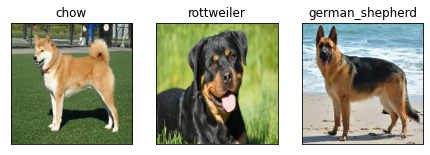

In [182]:
plt.figure(figsize=(10,10))
for index, image in enumerate(custom_images):
  plt.subplot(1,4,index+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[index])
  plt.imshow(image)

In [183]:
# Got rottweiler and german sheperd correctly, but shiba inu and belgian sheperd incorrectly

In [184]:
def plot_custom_pred(prediction_probs, labels, images, n=1):
  pred_prob, true_label, image = prediction_probs[n], labels[n], images[n]

  pred_label = get_pred_breed(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color="green"
  else:
    color="red"
  plt.title((f"Prediction: {pred_label} ({np.max(pred_prob)*100:2.0f}% confidence). Actual breed: {true_label}"), color=color)

In [185]:
def plot_custom_pred_confidence(prediction_probs, labels, n=1):
  """
  Plots the 10 most confident predictions
  """

  pred_prob, true_label = prediction_probs[n], labels[n]

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  plot = plt.bar(np.arange(len(top_10_pred_labels)), top_10_pred_values, color="red")
  plt.xticks(np.arange(len(top_10_pred_labels)), labels=top_10_pred_labels, rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    plot[np.argmax(top_10_pred_labels == true_label)].set_color("red")


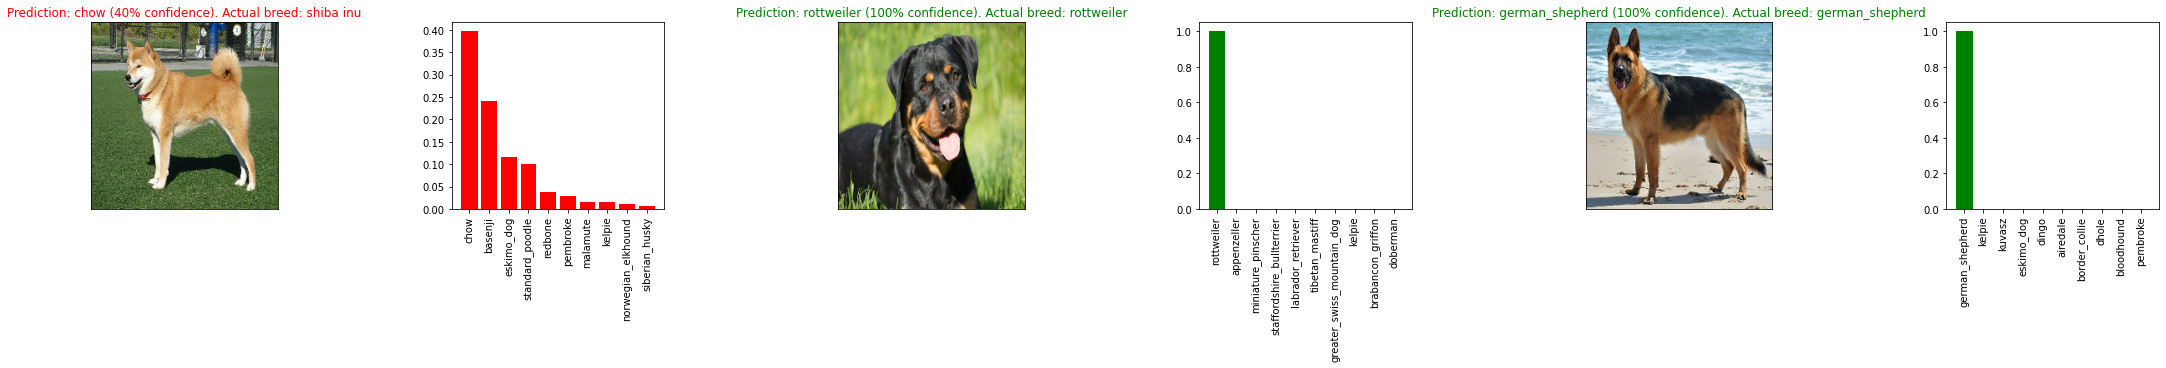

In [186]:
# Viewing predictions and their values
i_multiplier = 0
num_rows = 1
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_custom_pred(prediction_probs=custom_preds, labels=actual_breeds,
                   images=custom_images, n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_custom_pred_confidence(prediction_probs=custom_preds,
                labels=actual_breeds,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [155]:
# Turns out none of the images the model was tested on were of shiba inus
# Explains why it got the prediction wrong

for i in unique_breeds:
  if i == "shiba_inu":
    print(i)